In [1]:

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from torch.nn import functional as F

import time
import math

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

EXPERIMENT_ID = '6_5'

In [3]:
def create_data_loader(batch_size):
  # Split the provided CIFAR-10 train set (50,000 images) into your train and val sets
  # Use the first 40,000 images as your train set and the remaining 10,000 images as val set
  # Use all 10,000 images in the provided test set as your test set

  transform = transforms.Compose([
    transforms.ToTensor(),
      # This is the mean and the average of the cifar db because we are normalizing it.
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)), 
  ])

  # load cifar
  train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
  test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  # split train set into train and val
  train_set, val_set = torch.utils.data.random_split(train_set, [40000, 10000])

  # create data loaders
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,num_workers=4)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True,num_workers=4)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True,num_workers=4)

  train_loader = [(inputs.to(device), labels.to(device)) for inputs, labels in train_loader]
  val_loader = [(inputs.to(device), labels.to(device)) for inputs, labels in val_loader]
  test_loader = [(inputs.to(device), labels.to(device)) for inputs, labels in test_loader]




  return train_loader, val_loader, test_loader

In [4]:


class QuasiPolySynapse(nn.Module):
    def __init__(self, exponential_terms=3):
        super().__init__()
        # half chance the power to 1.5 and half chance to 1
        power_initial_value = 1
        self.power = nn.Parameter(torch.tensor([power_initial_value], dtype=torch.float32), requires_grad=True)
        self.term_weights = nn.Parameter(torch.randn(exponential_terms), requires_grad=True)

        
    def forward(self, x):
        y = self.term_weights[0] * x ** self.power
        for i in range(1, int(math.floor(self.power)-1)):
            y = y + self.term_weights[i] * x ** i
        return y
    
    def __repr__(self):
        return f'QuasiPolySynapse(power={self.power}, term_weights={self.term_weights})'



class QuasiPolyLayer(nn.Module):
  def __init__(self, in_features, out_features, product=False):
    super().__init__()
    self.out_features = out_features
    self.in_features = in_features
    # a 2d module list of quasipoly synapses sizes in_features x out_features
    self.synapses = nn.ModuleList([nn.ModuleList([QuasiPolySynapse(3) for _ in range(self.in_features)]) for _ in range(self.out_features)])
    self.bias = nn.Parameter(torch.randn(out_features), requires_grad=True)
    self.product = product
  
  def forward(self, x): # x is a batch of inputs

    y = torch.zeros(x.shape[0], self.out_features, dtype=torch.float32)

    y = y.to(device)
    
    # apply synapses to inputs
    for i in range(self.out_features):
        if self.product:
            y[:, i] = 1
        else:
            y[:, i] = 0
    
        for j in range(self.in_features):
            if self.product:
                y[:, i] = y[:, i] * self.synapses[i][j](x[:, j])
            else:
                y[:, i] = y[:, i] + self.synapses[i][j](x[:, j])

    # add bias
    y = y + self.bias

    return y
  


class AddEpsilon(nn.Module):
    def __init__(self, epsilon=1e-10): # 1e-10 is smallest possible float in pytorch
        super().__init__()
        self.epsilon = epsilon

    def forward(self, x):
        return x + self.epsilon

    

class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        in_channels = 3 # because cifar10 is colored

        self.features = nn.Sequential(
            
            nn.Conv2d(in_channels, 6*in_channels, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6*in_channels, 16*in_channels, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5*in_channels, 64*in_channels),  
            # nn.ReLU(),
            # nn.Linear(120*in_channels, 84*in_channels),
            # QuasiPolyLayer(60*in_channels, 21*in_channels),
            nn.ReLU(),
            # nn.Linear(64*in_channels, num_classes)
            AddEpsilon(),
            QuasiPolyLayer(8*in_channels, num_classes)
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits



In [5]:
def init_train_var(model):
  
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.2 ) # set momentum to 0.2 after trial and error
  # optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.00001)
  # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  return criterion, optimizer

In [6]:
def test(model_path, test_loader):
  # use the provided test loader
  # return the test accuracy
  model = torch.load(model_path)
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    test_acc = correct / total
  return test_acc


In [7]:
BATCH_SIZE = 1024
train_loader, val_loader, test_loader = create_data_loader(batch_size=BATCH_SIZE)


model = LeNet5(10)
model = model.to(device)
# model = nn.DataParallel(model)
criterion, optimizer = init_train_var(model)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
EPOCH_COUNT = 800

In [9]:
%%time

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(EPOCH_COUNT):
    model.train()
    train_loss = 0
    train_correct = 0
    # for each batch
    for i, (inputs, labels) in enumerate(train_loader):
        # count the number of weights with very small magnitute < 1e-3
        nans_count = 0
        for param in model.parameters():
            if param.grad is not None:
                nans_count += torch.sum(torch.isnan(param.grad)).item()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print all gradients of the first synapse
        # print(f"synapse grads : {model.classifier[-1].synapses[0][0].main[0].grad}")
        # print(f"weights of first layer {model.classifier[-1].synapses[0][0]}")
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()


    print(f'Epoch {epoch+1}/{EPOCH_COUNT}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_correct/40000:.4f}')
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct/40000)

    # validate
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
    val_acc = val_correct/10000
    print(f'Epoch {epoch+1}/{EPOCH_COUNT}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    



Epoch 1/800, Train Loss: 86.7494, Train Accuracy: 0.2162
Epoch 1/800, Val Loss: 20.5785, Val Accuracy: 0.2623
Epoch 2/800, Train Loss: 79.3723, Train Accuracy: 0.2954
Epoch 2/800, Val Loss: 19.6835, Val Accuracy: 0.2930
Epoch 3/800, Train Loss: 76.3777, Train Accuracy: 0.3237
Epoch 3/800, Val Loss: 19.0648, Val Accuracy: 0.3155
Epoch 4/800, Train Loss: 74.1713, Train Accuracy: 0.3458
Epoch 4/800, Val Loss: 18.5951, Val Accuracy: 0.3395
Epoch 5/800, Train Loss: 72.3196, Train Accuracy: 0.3645
Epoch 5/800, Val Loss: 18.1778, Val Accuracy: 0.3507
Epoch 6/800, Train Loss: 70.6018, Train Accuracy: 0.3794
Epoch 6/800, Val Loss: 17.7963, Val Accuracy: 0.3694
Epoch 7/800, Train Loss: 69.0600, Train Accuracy: 0.3947
Epoch 7/800, Val Loss: 17.4626, Val Accuracy: 0.3818
Epoch 8/800, Train Loss: 67.6704, Train Accuracy: 0.4075
Epoch 8/800, Val Loss: 17.1653, Val Accuracy: 0.3908
Epoch 9/800, Train Loss: 66.3950, Train Accuracy: 0.4178
Epoch 9/800, Val Loss: 16.8917, Val Accuracy: 0.4012
Epoch 10/8

KeyboardInterrupt: 

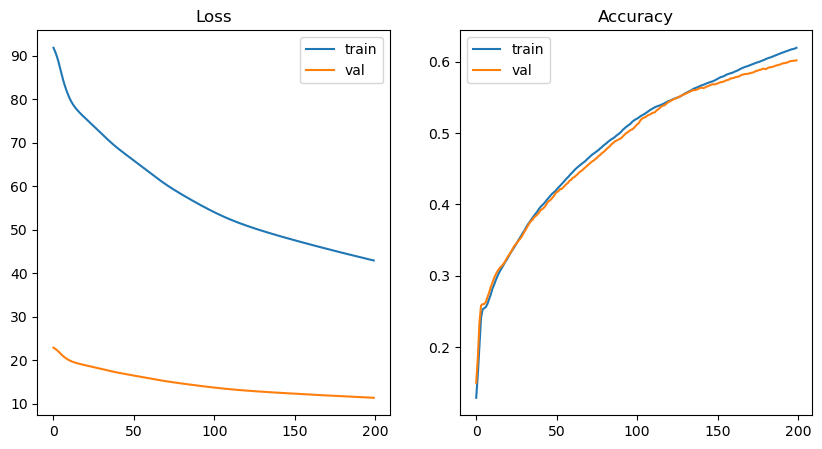

In [ ]:
# plot the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='val')
plt.title('Accuracy')
plt.legend()


# save plot to storage
plt.savefig(f"experiment_{EXPERIMENT_ID}_plot.png")

plt.show()

# save model to storage
torch.save(model, f"experiment_{EXPERIMENT_ID}_model.pth")

In [ ]:
# print weights and powers of quasi poly layer

quasi_poly_layer = model.classifier[-1]
for i in range(quasi_poly_layer.out_features):
    for j in range(quasi_poly_layer.in_features):
        print(f'QuasiPolySynapse {i} {j} power: {quasi_poly_layer.synapses[i][j].power.item()}')
        print(f'QuasiPolySynapse {i} {j} term weights: {quasi_poly_layer.synapses[i][j].term_weights.data}')
        



AttributeError: 'Linear' object has no attribute 'synapses'